## DRAFT VERSION.

In this notebook, we are trying to reproduce [the paper](http://scuba.usc.edu/pdf/jati2017_Speaker2Vec.pdf).

For review of the paper, you can look [here](https://hedonistrh.github.io/2018-07-09-Literature-Review-for-Speaker-Change-Detection/)

## Feature Extraction

_"We have adopted 40 dimensional high definition MFCC features extracted from 40 mel-spaced filters over a 25ms hamming window with a shift of 10ms using Kaldi toolkit"_ However, I will use [Librosa](https://librosa.github.io).



## Prepare Data

_"We have used d = 100 frames (1s) for all training scenarios. This makes the size of input and output layers of the DNN models to be 4000."_

_"40 mel-spaced filters over a 25ms hamming window with a shift of 10ms"_

In [ ]:
!mkdir audio_files # this folder store audio_files

We will use some data from Youtube. To download these files, [youtube-dl](https://rg3.github.io/youtube-dl/index.html) is used.

In [ ]:
# https://askubuntu.com/questions/564567/how-to-download-playlist-from-youtube-dl
# https://www.slashgeek.net/2016/06/24/5-youtube-dl-tips-might-not-know/
!youtube-dl --extract-audio --audio-format m4a -o "./audio_files/%(title)s.%(ext)s" https://www.youtube.com/playlist?list=

In [ ]:
!ls

** YAAFE Implementation **

In [30]:
f = open("featureplan_speaker2vec.txt", "w")
f.write("mfcc: MFCC blockSize=400 stepSize=160 CepsNbCoeffs=40 CepsIgnoreFirstCoeff=0")
f.close() 

In [34]:
from numpy import genfromtxt
import numpy as np
import os
import glob

import librosa
import os
import glob
import numpy as np
import math
import sys
    

def create_numpy_for_audio(audio_file, featureplan = "",  feature_extractor= "yaafe", hop=10, win_len=25):
    ## This function is based on YAAFE and librosa. Its arguments:
    # audio_file: Path of audio file, it can be wav, mp3, ogg etc.
    # featureplan: Text file which introduce which features will be extracted. (we need it for YAAFE
    # feature_extractor: Which library will be used to extract features
    # hop: Hop length (we need it for Librosa)
    # win_len: Window length (we need it for Librosa)
    
    ## It will return 2D Array which is features of audio file.
    
    if (feature_extractor=="yaafe"):
        !yaafe -c $featureplan -r 16000 $audio_file -p Precision=6 -p Metadata=False -n
        filename = (audio_file.split("/")[-1]).split(".")[0]

        my_data = genfromtxt(audio_file + ".mfcc.csv", delimiter=',')


        # Previous codes creates csv file for features to load numpy array. After that, we can 
        # remove them.
        os.remove(audio_file + ".mfcc.csv")


        return my_data
    
    if (feature_extractor=="librosa"):
        audio, sr = librosa.load(filename)
        # print (audio.shape, sr)
        # https://github.com/librosa/librosa/issues/584
        mfccs = librosa.feature.mfcc(audio, sr, n_mfcc=40, hop_length=int(float(hop/1000)*sr), n_fft=int(float(win_len/1000)*sr))
        return mfccs


def create_data_for_unsupervised(root_dir, featureplan, file_type="*mp3", feature_extractor="yaafe"):
    ## This function is based YAAFE and Librosa. Its arguments:
    # root_dir: Folder which stores audio files
    # featureplan: Text file which introduce which features will be extracted. (we need it for YAAFE)
    # file_type: Type of audio files. Default is mp3
    # feature_extractor: Which library will be used to extract features
    
    all_audio_paths = glob.glob(os.path.join(root_dir, file_type))
    matrix_of_audio_wav = []

   
    for single_audio_path in all_audio_paths:
        print (single_audio_path)
        matrix_of_single_audio = create_numpy_for_audio(featureplan, single_audio_path)
        array_of_single_audio = np.ravel(matrix_of_single_audio)
        
        if (matrix_of_single_audio is not None):
            print (matrix_of_single_audio.shape)
            matrix_of_all_audio.extend(array_of_single_audio)
            print (single_audio_path + " is done.")
            
    audio_array = np.asarray(matrix_of_all_audio)
    audio_array = np.reshape(matrix_of_all_audio, (-1, 40))
    input_array = []
    output_array = []

    print (audio_array.shape)
    
    start_point = 0
    
    while (start_point+200 < audio_array.shape[0]):
        single_input = audio_array[start_point:start_point+100, 0:40]
        single_output = audio_array[start_point+100:start_point+200, 0:40]
        input_array.append(single_input)
        output_array.append(single_output)
        start_point += 100
        
        
    input_array = np.asarray(input_array)
    input_array = input_array.reshape((len(input_array), np.prod(input_array.shape[1:])))  
    print(input_array.shape)

    output_array = np.asarray(output_array)
    output_array = output_array.reshape((len(output_array), np.prod(output_array.shape[1:])))  
    print(output_array.shape)
    
    return (input_array, output_array)

process file ./ES2009a.Mix-Headset.wav
done in 2.26825s


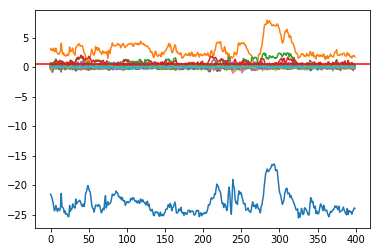

In [35]:
a = create_numpy_for_audio( "./ES2009a.Mix-Headset.wav", "featureplan_speaker2vec.txt",)
import matplotlib.pyplot as pp
%matplotlib inline

pp.plot(a[200:600])
pp.axhline(y=0.5, color='r', linestyle='-')
pp.show()

In [ ]:
create_data_for_unsupervised("./audio_files/", "featureplan_speaker2vec.txt")

In [21]:
import os
import glob
import numpy as np
import sys

def upload_npy_to_arrays(root_dir, from_ep = 0, to_ep=0):
    ## If we have stored numpy arrays, we can just load into 
    # numpy array via this function. Its arguments:
    # root_dir: Folder which stores numpy arrays
    # from_ep: Location of first file which will be loaded into array
    # to_ep: Location of last file which will be loaded into array
    
    all_npy_paths = glob.glob(os.path.join(root_dir, '*npy'))
    matrix_of_all_audio = []

    num = 0
    for single_npy_path in all_npy_paths:
        num += 1
        if (num >= from_ep):
            array_of_single_audio = np.load(single_npy_path)
            
            if (num > to_ep):
                break
                    
            else:
                if (array_of_single_audio is not None):
                     matrix_of_all_audio.extend(array_of_single_audio)
            
    audio_array = np.asarray(matrix_of_all_audio)
    audio_array = np.reshape(matrix_of_all_audio, (-1,40))
    input_array = []
    output_array = []

    print (audio_array.shape)
    
    start_point = 0
    
    while (start_point+200 < audio_array.shape[0]):
        single_input = audio_array[start_point:start_point+100, 0:40]
        single_output = audio_array[start_point+100:start_point+200, 0:40]
        input_array.append(single_input)
        output_array.append(single_output)
        start_point += 100
        
        
        
    input_array = np.asarray(input_array)
    input_array = input_array.reshape((len(input_array), np.prod(input_array.shape[1:])))  
    print(input_array.shape)

    output_array = np.asarray(output_array)
    output_array = output_array.reshape((len(output_array), np.prod(output_array.shape[1:])))  
    print(output_array.shape)
    
    return (input_array, output_array)

In [22]:
input_array, output_array = upload_npy_to_arrays('./yaafe_ami_storage/', 0, 3)

(560766, 59)
(5606, 4000)
(5606, 4000)


**Let's focus on AMI Corpus**

In the [dev.mdtm](https://github.com/pyannote/pyannote-db-odessa-ami/tree/master/AMI/data/speaker_diarization), we can see the:
    - filename, offset, duration, "speaker NA unknown", id of speaker

We should focus on this. We can download the corresponding .wav files easily. 

Firsly, I will create database for speaker change detection. It will be not-optimized until the end of test.

In [ ]:
# !ls

In [ ]:
mkdir txt_files

In [8]:
import sys
import numpy as np

def create_ground_truth(main_set):
    ## It takes mdtm file and creates text file
    # which will store end time of each speak
    
    # start_time_array = []
    end_time_array = []
    output_frame_array = []
    with open(main_set) as f:
        content = f.readlines()
    # you may also want to remove whitespace characters like `\n` at the end of each line
    content = [x.strip() for x in content] 
    tmp_filename = content[0].split(' ')[0]
    # sys.exit("WAIT, TEST :)")

    for single_line in content:
        filename = single_line.split(' ')[0]
        # print (filename)
        if (filename != tmp_filename):
            # start_time_array = np.asarray(start_time_array)
            # np.savetxt(fname=tmp_filename + "_start_time.txt", X=start_time_array, delimiter=' ', fmt='%1.3f')
            # end_time_array = np.asarray(end_time_array)
            np.savetxt(fname=tmp_filename + "_end_time.txt", X=end_time_array, delimiter=' ', fmt='%1.3f')
            # start_time_array = []
            end_time_array = []
            
        tmp_filename = single_line.split(' ')[0]
        offset = float(single_line.split(' ')[2])
        duration = float(single_line.split(' ')[3])
        end_time = offset+duration
        # start_time_array.append(offset)
        end_time_array.append(end_time)

In [ ]:
cd txt_files

In [ ]:
!wget https://raw.githubusercontent.com/pyannote/pyannote-db-odessa-ami/master/AMI/data/speaker_diarization/dev.mdtm

In [ ]:
!wget https://raw.githubusercontent.com/pyannote/pyannote-db-odessa-ami/master/AMI/data/speaker_diarization/tst.mdtm

In [ ]:
!wget https://raw.githubusercontent.com/pyannote/pyannote-db-odessa-ami/master/AMI/data/speaker_diarization/trn.mdtm

In [ ]:
create_ground_truth('dev.mdtm')

In [ ]:
create_ground_truth('trn.mdtm')

In [ ]:
create_ground_truth('tst.mdtm')

In [ ]:
cd ..

## Deep Learning Architectures

- They use 2 different autoencoder. 
    - Smaller is 4000 → 2000 → 40 → 2000 → 4000
    - Larger is 4000 → 6000 → 2000 → 40 → 2000 → 6000 → 4000
![Image of Autoencoder](https://docs.google.com/uc?id=1epse9ba1fRTdmyN3pF0XoECEHcaiLsa3)


In [26]:
from keras import layers
from keras import models
from keras import optimizers
import keras
from keras.models import Model
import tensorflow as tf
from keras.layers.advanced_activations import *


input_frame = keras.Input(shape=(4000,), name='main_input')
encoded_1 = layers.Dense(4000, activation='relu', name='encoded_1')(input_frame) # not quite sure about the activation
encoded_2 = layers.Dense(2000, activation='relu', name='encoded_2')(encoded_1)

embedding = layers.Dense(40, activation='relu', name='embedding')(encoded_2)

decoded_1 = layers.Dense(2000, activation='relu', name='decoded_1')(embedding)
decoded_2 = layers.Dense(4000, activation='linear', name='decoded_2')(decoded_1)

autoencoder = Model(input_frame, decoded_2)

rmsprop = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
autoencoder.compile(optimizer='rmsprop', loss='mean_squared_logarithmic_error')

autoencoder.summary()

/home/herdogan/anaconda3/envs/pyannote/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/herdogan/anaconda3/envs/pyannote/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/herdogan/anaconda3/envs/pyannote/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 4000)              0         
_________________________________________________________________
encoded_1 (Dense)            (None, 4000)              16004000  
_________________________________________________________________
encoded_2 (Dense)            (None, 2000)              8002000   
_________________________________________________________________
embedding (Dense)            (None, 40)                80040     
_________________________________________________________________
decoded_1 (Dense)            (None, 2000)              82000     
_________________________________________________________________
decoded_2 (Dense)            (None, 4000)              8004000   
Total params: 32,172,040
Trainable params: 32,172,040
Non-trainable params: 0
________________________________________________________________

In [27]:
# from keras.models import load_model
autoencoder.load_weights('speaker2vec_weights.h5')

In [ ]:
from keras.models import load_model


how_many_step = 30
ix_step = 0
from_epi = 0

while (ix_step < how_many_step):
    ix_step += 1
    
    input_array, output_array = upload_npy_to_arrays('./npy_files/', from_ep=from_epi, to_ep=from_epi+4)
    
    try:
        autoencoder.fit(input_array, output_array,
               epochs=2,
               batch_size=16,
               shuffle=True)
        autoencoder.save_weights('speaker2vec_weights.h5')    

    except:
        print ("pass this epoch")
        pass
    
    # https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model

    
    input_array = []
    output_array = []
    
    from_epi += 4

**Let's try to detect speaker change points. We will use encoder part of autoencoder.**
- Firstly, extract the embedding,
- Compare neighboorhood embeddings via different parameters,
- If result of comparision exceed determined threshold, it represent the speaker change point.

In [28]:
embedding_system = Model(input_frame, embedding) # create system to extraxt embed.

Now, we have embedding system. We should feed this sytem via input frames.

In [103]:
from scipy.signal import savgol_filter
import scipy 
import more_itertools as mit


def KL(P,Q):
    """ Epsilon is used here to avoid conditional code for
    checking that neither P nor Q is equal to 0. """
    epsilon = 0.00001

     # You may want to instead make copies to avoid changing the np arrays.
    P = P+epsilon
    Q = Q+epsilon

    divergence = np.sum(P*np.log(P/Q))
    return divergence

def create_prediction(audio_file, hop, win_len, threshold, embedding_system, featureplan="", feature_extractor="librosa"):
    ## This takes audio file and create prediction to understand speaker change points.
    # Its arguments:
    # audio_file: Path of audio file, it can be wav, mp3, ogg etc.
    # hop: Hop length (we need it for Librosa)
    # win_len: Window length (we need it for Librosa)
    # threshold: Threshold value for speaker chanhe point. Apply into smoothed version of array
    # featureplan: Text file which introduce which features will be extracted. (we need it for YAAFE)
    # feature_extractor: Which library will be used to extract features
    
    ## It will return:
    # prediction_array_sec = Array which stores which second we have speaker change points.
    # KL_array_to_0_1: Min max normalized version of KL Divergence array between embeds.
    # KL_array_smooth: Smoothed version of KL_array_to_0_1

    
    KL_array = []
    prediction_array_sec = []
    
    # at that point, we should not use overlapping segment
    # https://github.com/librosa/librosa/issues/584
    if (feature_extractor=="librosa"):
        audio, sr = librosa.load(audio_file)
        mfccs = librosa.feature.mfcc(audio, sr, n_mfcc=40, hop_length=int(hop/1000*sr), n_fft=int(win_len/1000*sr))
    if (feature_extractor=="yaafe"):
        mfccs = create_numpy_for_audio(audio_file, featureplan)
    # now we have mfcc of all audio file.
    
    offset=0
    print ("K")
    
    while (offset+201 < mfccs.shape[1]):
    # line_mfccs = np.ravel(mfccs, order='F')
        first_frame = np.ravel(mfccs[0:40,offset:offset+100])
        first_frame = np.expand_dims(first_frame, axis=0)
        first_embed = embedding_system.predict(first_frame)
        
        second_frame = np.ravel(mfccs[0:40,offset+101:offset+201])
        second_frame = np.expand_dims(second_frame, axis=0)
        second_embed = embedding_system.predict(second_frame)
        KL_array.append(KL(first_embed, second_embed))
        offset += 1
        
        
    print ("total offset: ", offset)
    
    KL_array = np.asarray(KL_array)
        
    # min max normalization
    KL_array_to_0_1 = (KL_array-min(KL_array))/(max(KL_array)-min(KL_array))
    KL_array_to_0_1 = np.asarray(KL_array_to_0_1)
    # print (KL_array_to_0_1)    
    
    # Now, we should apply lowpass filter to get smooth KL curve.
    # https://stats.stackexchange.com/questions/323069/can-kl-divergence-ever-be-greater-than-1
    # https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way
    KL_array_smooth = savgol_filter(KL_array_to_0_1, 21, 7)
    KL_array_smooth = np.asarray(KL_array_smooth)    
        
    offset = 0
    for KL_value in KL_array_smooth:
        if (KL_value > threshold):
            ms_version = float(win_len + ((offset+1) * hop)) # milisecond version to represent end point of first embed       
            prediction_array_sec.append(ms_version/1000)
            
        offset += 1
            
    prediction_array_sec = np.asarray(prediction_array_sec)
    
    prediction_array_msec = prediction_array_sec*1000
    
    prediction_array_smooth = []
    for pred in prediction_array_msec:
        if (pred-hop not in prediction_array_msec):
            prediction_array_smooth.append(pred*0.001)
            
            
    prediction_array_tenth_ms = np.asarray(prediction_array_msec)/10

    list_cons = [list(group) for group in mit.consecutive_groups(prediction_array_tenth_ms)]
    
    mean_s = []
    
    for single_list_cons in list_cons:
        # print (np.mean(single_list_cons))
        mean_s.append(np.mean(single_list_cons)*0.01)
                
    np.savetxt(fname=audio_file.split("/")[-1] + "_prediction.txt", X=mean_s, 
               delimiter=' ', fmt='%1.3f')

    return (prediction_array_sec, KL_array_to_0_1, KL_array_smooth)

In [104]:
def txt_file_to_matrix(filename, type_of_text, hop=10, win_len=25):
    ## It takes the reference end time text file or prediction text file and return output array which represent the which frames has a speaker change point.
    # filename= Which file will be considered.
    # hop: Hop length (we need it for Librosa)
    # win_len: Window length (we need it for Librosa)
    
    
    matrix_of_single_audio = np.load("/home/herdogan/Desktop/SpChangeDetect/pyannote-audio/tutorials/feature-extraction/AMI/" + filename + ".Mix-Headset.npy")
    
    if (type_of_text == "reference"):
        main_set = "./txt_files/" + filename + "_end_time.txt"# FILENAME PATH for TXT
    
    
    if (type_of_text == "prediction"):
        main_set = "./" + filename + "_prediction.txt"# FILENAME PATH for TXT

    end_time_array_second = []


    with open(main_set) as f:
        content = f.readlines()
        
    content = [x.strip() for x in content] 

    for single_line in content:

        end_time_array_second.append(single_line)

    output_array = np.zeros(matrix_of_single_audio.shape[0])

    for end_time in end_time_array_second:
        end_time_ms = float(end_time)*1000
        which_start_hop = (end_time_ms-win_len)/hop # now we know, milisecond version of change
                                    # which is located after which_hop paramater
                                    # add 2 and round to up
        which_end_hop = end_time_ms/hop # round to up

        start_location = math.ceil(which_start_hop + 1)
        end_location = math.ceil(which_end_hop)

        # print ("s:", start_location)
        # print ("e:", end_location)
        output_array[start_location:end_location+1] = 1.0

    return (output_array)

**Now, implement transfer learning part. We will do it because of unsupervised domain adaptation.**
- Find the speaker change points by trained DNN,
- Get all possible speaker homogeneous regions,
- Retrain the same DNN again on these homogeneous segments of speech.

In [105]:
%%time

change_points, arr, arr_s = create_prediction('./test_16k.wav', hop=10, win_len=25, threshold=0.72, embedding_system=embedding_system)

K
total offset:  5243
CPU times: user 9min 59s, sys: 9min 54s, total: 19min 53s
Wall time: 2min 34s


/home/herdogan/anaconda3/envs/pyannote/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [99]:
arr_s.mean()

0.40851608

In [96]:
offset = 0
hop = 10
win_len = 25
threshold = 0.72

print ("thres:", threshold)
for KL_value in arr_s:
    # print (KL_value)
    if (KL_value > threshold):
        print (offset)
        ms_version = float(win_len + ((offset+1) * hop)) # milisecond version to represent end point of first embed       
        

    offset += 1

thres: 0.72
0.06618712
0.058879934
0.051527854
0.044890024
0.039453886
0.035430416
0.03278676
0.03130628
0.03066595
0.03052109
0.030587405
0.030576488
0.031031165
0.03143635
0.03229393
0.034571446
0.03889834
0.04460074
0.050053768
0.055406284
0.060885392
0.06704503
0.07355655
0.08026718
0.08679471
0.09202669
0.09655316
0.10140456
0.10707021
0.11369108
0.12104486
0.12790821
0.13433239
0.13974692
0.14485964
0.14932472
0.15528104
0.16406152
0.17534897
0.18763617
0.19957042
0.2103851
0.21879946
0.22424689
0.22821705
0.23105633
0.23351915
0.23532711
0.23671979
0.23833765
0.24048531
0.24261549
0.24496137
0.2482691
0.25343162
0.25864366
0.26420388
0.2712935
0.28011334
0.28933546
0.2976646
0.30545017
0.31310588
0.31931773
0.32612112
0.33445513
0.3457039
0.35917848
0.37454882
0.3912718
0.40775147
0.42090213
0.43040958
0.438131
0.4448707
0.4514878
0.45778427
0.46366608
0.46797645
0.47126827
0.4743272
0.47781417
0.48120955
0.48408023
0.48707414
0.49198148
0.49776965
0.502122
0.5043229
0.5063301
0

In [84]:
len(change_points)

555

In [90]:
len(arr_s)

5243

In [ ]:
import matplotlib.pyplot as pp

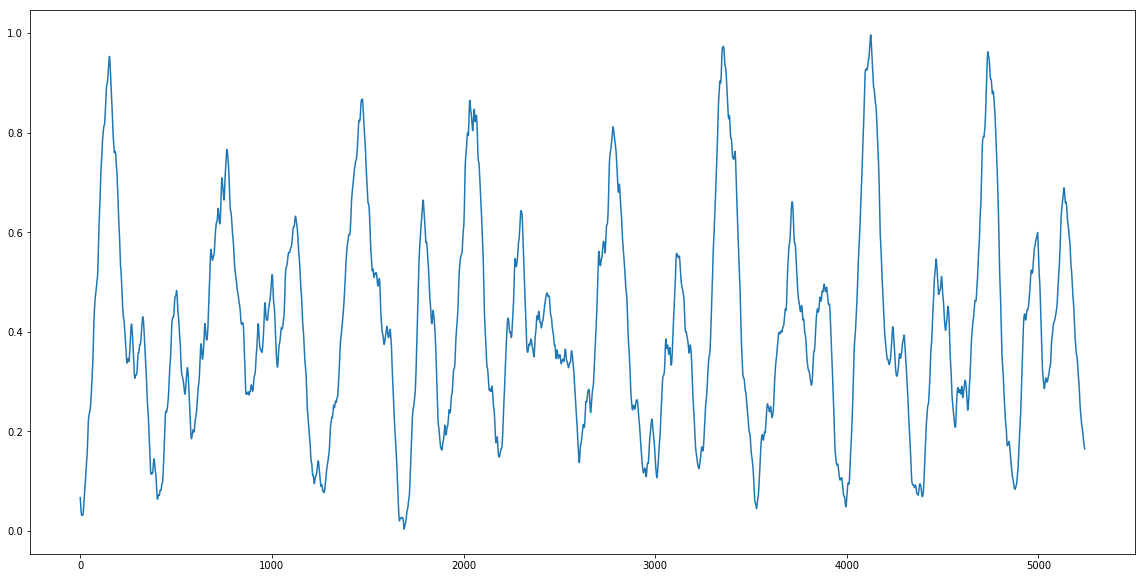

In [91]:
pp.plot(arr_s)
pp.rcParams['figure.figsize'] = (19.8, 10.0)

pp.show()

In [ ]:
pp.plot(arr_s)
pp.rcParams['figure.figsize'] = (19.8, 12.0)

pp.axhline(y=0.42, color='r', linestyle='-')
pp.show()

In [ ]:
pp.plot(grounth_truth_matrix("EN2001a", 10, 25))
pp.show()

In [ ]:
aa = grounth_truth_matrix("EN2001a", 10, 25)
bb = pred_file_to_frame("EN2001a", 10, 25)

In [ ]:
print (aa.shape)
print (bb.shape)

In [ ]:
x = np.arange(1, len(aa)+1)

In [ ]:
import matplotlib.pyplot as pp
%matplotlib inline

pp.rcParams['figure.figsize'] = (19.8, 10.0)

bb = bb * 0.9

pp.plot(x[0:20000], aa[10000:30000], 'x', color='black');
pp.plot(x[0:20000], bb[10000:30000], '.', color='pink');

# pp.axhline(y=thres, color='r', linestyle='-')
pp.show()

In [ ]:
pp.plot(arr)
pp.plot(savgol_filter(arr, 51, 3))

pp.show()

In [ ]:
pp.plot(arr)
pp.plot(savgol_filter(arr, 31, 3))

pp.show()

In [ ]:
pp.plot(arr)
pp.plot(savgol_filter(arr, 11, 3))

pp.show()

In [ ]:
pp.plot(arr)
pp.plot(savgol_filter(arr, 11, 7))

pp.show()

In [ ]:
change_points = create_prediction('test.wav', hop=10, win_len=25, threshold=0.6, embedding_system=embedding_system)

# This is for unsupervised adaptation.

## Very bad according to optimization view. !!!
def creata_data_for_unsuper_adaptation(root_dir, hop, win_len):
    all_wav_paths = glob.glob(os.path.join(root_dir, '*m4a'))
    matrix_of_all_wav = []
    
    input_array = []
    output_array = []
    
    for single_wav_path in all_wav_paths:
        prediction_array = create_prediction(wav_file, hop, win_len, threshold, embedding_system)
        matrix_of_single_wav = wav_to_matrix(single_wav_path, hop, win_len)
            
        start_point = 0
        while (start_point+200 < matrix_of_single_wav.shape[1]):
            change = 0 # value to check any value in prediction array is in range of frame
            for single_change in prediction_array:
                if (single_change in range(float(win_len + ((offset) * hop)), 
                                               float(win_len + ((offset+200) * hop)))):
                    change = 1
            if (change == 0):
                single_input = wav_array[0:40,start_point:start_point+100]
                single_output = wav_array[:40, start_point+100:start_point+200]
                input_array.append(single_input)
                output_array.append(single_output)
            start_point += 100

    input_array = np.asarray(input_array)
    input_array = input_array.reshape((len(input_array), np.prod(input_array.shape[1:])))
    
    output_array = np.asarray(output_array)
    output_array = output_array.reshape((len(output_array)*output_array.shape[1], output_array.shape[2]*output_array.shape[3] ))

    print(output_array.shape)
    
    return (input_array, output_array)
